# Deep Learning
## Deep Domain Adaptation - SVHN to MNIST

**Name:** Margonis Phevos          
**ID:** f3352317                
**Date:** June, 2024

---

## Table of Contents
1. [Introduction](#introduction)
1. [No Adaptation (Baseline)](#baseline-1---no-adaptation-na)
2. [Train on Target (Baseline)](#baseline-2---train-on-target-tot)
3. [Domain-Adversarial Neural Network (DANN)](#domain-adversarial-neural-network-dann)
5. [Results](#results)

---

## Introduction

Deep domain adaptation from SVHN to MNIST involves transferring learned representations from the Street View House Numbers (SVHN) dataset to the Modified National Institute of Standards and Technology (MNIST) dataset. This task is challenging due to the significant differences in image characteristics between the two datasets. Two common baselines for evaluating domain adaptation performance are "No Adaptation," where a model trained on SVHN is directly tested on MNIST without any adaptation, and "Train on Test," where a model is trained and tested on the same target domain (MNIST). These baselines provide benchmarks to assess the effectiveness of domain adaptation techniques.

The Domain-Adversarial Neural Network (DANN) algorithm uses adversarial training to learn domain-invariant features, enhancing cross-domain performance. Applied to SVHN to MNIST adaptation, DANN aligns feature distributions using a gradient reversal layer, significantly improving digit classification accuracy. This method surpasses the NA baseline by effectively bridging the visual domain gap.
### SVHN

<img src=".img/svhn.jpg" alt="description" width="300" height="200">


The Street View House Numbers (SVHN) dataset is a widely used benchmark for digit classification. It includes 600,000 RGB images, each sized 32×32 pixels, featuring printed digits ranging from 0 to 9. These digits are extracted from photos of house number plates and are centered in the images, although adjacent digits and other elements remain visible. The dataset is divided into three parts: a training set, a testing set, and an extra set of 530,000 images. The extra set contains less challenging images that can aid in the training process. Only the training and the testing set has been used in this experiment.

Source: [https://paperswithcode.com/dataset/svhn](https://paperswithcode.com/dataset/svhn)

### MNIST

<img src=".img/mnist.jpg" alt="description" width="300" height="200">

The MNIST database is a well-known collection of handwritten digit images used for training and testing machine learning models. It consists of 60,000 training examples and 10,000 test examples. Derived from the larger NIST Special Databases 1 and 3, MNIST features size-normalized and centered monochrome images. Originally black and white, these images were normalized to fit within a 20x20 pixel box while maintaining aspect ratio, then centered in a 28x28 pixel field. Grey levels were introduced through anti-aliasing during the normalization process.

Source: [https://paperswithcode.com/dataset/mnist](https://paperswithcode.com/dataset/mnist)

---

## Baseline 1 - No Adaptation (NA)

In [ ]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Function
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision import datasets, transforms

In [ ]:
# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

### Define the dataloaders

In [ ]:
# Transforms for SVHN (source) and MNIST (target)
source_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

target_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load SVHN and MNIST datasets
source_train_dataset = datasets.SVHN(root='data', split='train', download=True, transform=source_transform)
source_test_dataset = datasets.SVHN(root='data', split='test', download=True, transform=source_transform)
target_train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=target_transform)
target_test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=target_transform)

# Verify the number of samples in each loader
print(f'Number of samples in source train loader: {len(source_train_dataset)}')
print(f'Number of samples in source test loader: {len(source_test_dataset)}')
print(f'Number of samples in target train loader: {len(target_train_dataset)}')
print(f'Number of samples in target test loader: {len(target_test_dataset)}')

Using downloaded and verified file: data\train_32x32.mat
Using downloaded and verified file: data\test_32x32.mat
Number of samples in source train loader: 73257
Number of samples in source test loader: 26032
Number of samples in target train loader: 60000
Number of samples in target test loader: 10000


In [ ]:
# Data loaders
source_train_loader = DataLoader(source_train_dataset, batch_size=64, shuffle=True, num_workers=2)
source_test_loader = DataLoader(source_test_dataset, batch_size=64, shuffle=False, num_workers=2)
target_train_loader = DataLoader(target_train_dataset, batch_size=64, shuffle=True, num_workers=2)
target_test_loader = DataLoader(target_test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Verify the number of samples in each loader
print(f'Number of samples in source train loader: {len(source_train_loader.dataset)}')
print(f'Number of samples in source test loader: {len(source_test_loader.dataset)}')
print(f'Number of samples in target train loader: {len(target_train_loader.dataset)}')
print(f'Number of samples in target test loader: {len(target_test_loader.dataset)}')

Number of samples in source train loader: 73257
Number of samples in source test loader: 26032
Number of samples in target train loader: 60000
Number of samples in target test loader: 10000


### Define my simple LeNet Model

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128*4*4, 1024)
        self.fc2 = nn.Linear(1024, 100)
        self.fc3 = nn.Linear(100, 10)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 128*4*4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Train the model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []

def train(model, train_loader, optimizer, criterion, epoch):
    model.train()
    epoch_loss = 0.0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    average_loss = epoch_loss / len(train_loader)
    train_losses.append(average_loss)
    print(f'====> Epoch: {epoch} Average train loss: {average_loss:.4f}')

def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()
    
    average_val_loss = val_loss / len(val_loader)
    return average_val_loss

best_val_loss = float('inf')
best_epoch = -1
patience = 10
counter = 0

for epoch in range(1, 101):
    train(model, source_train_loader, optimizer, criterion, epoch)
    val_loss = validate(model, source_test_loader, criterion)
    val_losses.append(val_loss)
    print(f'====> Epoch: {epoch} Validation loss: {val_loss:.4f}')
    
    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'models/best_model_base.pth')
        counter = 0  # Reset counter if validation loss improves
    else:
        counter += 1
    
    # Early stopping
    if counter >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

====> Epoch: 1 Average train loss: 0.6259
====> Epoch: 1 Validation loss: 0.4473
====> Epoch: 2 Average train loss: 0.3581
====> Epoch: 2 Validation loss: 0.3403
====> Epoch: 3 Average train loss: 0.3001
====> Epoch: 3 Validation loss: 0.3136
====> Epoch: 4 Average train loss: 0.2648
====> Epoch: 4 Validation loss: 0.2968
====> Epoch: 5 Average train loss: 0.2358
====> Epoch: 5 Validation loss: 0.3280
====> Epoch: 6 Average train loss: 0.2106
====> Epoch: 6 Validation loss: 0.2900
====> Epoch: 7 Average train loss: 0.1882
====> Epoch: 7 Validation loss: 0.2963
====> Epoch: 8 Average train loss: 0.1703
====> Epoch: 8 Validation loss: 0.2804
====> Epoch: 9 Average train loss: 0.1529
====> Epoch: 9 Validation loss: 0.2955
====> Epoch: 10 Average train loss: 0.1314
====> Epoch: 10 Validation loss: 0.3044
====> Epoch: 11 Average train loss: 0.1225
====> Epoch: 11 Validation loss: 0.3209
====> Epoch: 12 Average train loss: 0.1069
====> Epoch: 12 Validation loss: 0.3445
====> Epoch: 13 Averag

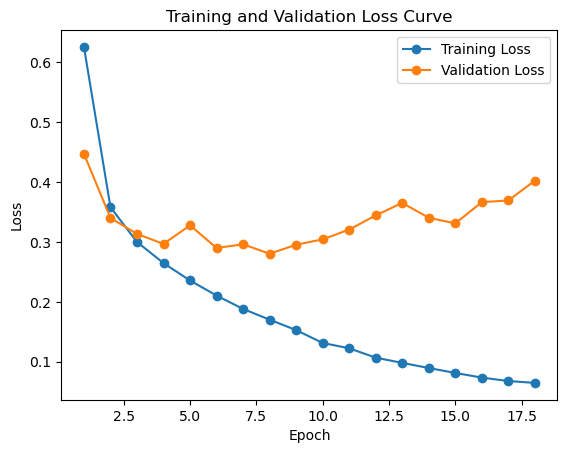

The best epoch is 8 with a validation loss of 0.2804


In [ ]:

# Plot the training and validation loss curves
plt.figure()
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()

print(f'The best epoch is {best_epoch} with a validation loss of {best_val_loss:.4f}')


### Test DA

In [ ]:
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({100. * correct / len(test_loader.dataset):.0f}%)\n')

In [ ]:
# Load the best model weights
model.load_state_dict(torch.load('models/best_model_base.pth'))

# Evaluate
print(" Evaluate model on source_test: ")
test(model, source_test_loader, criterion)

print("No-Adaptation results: ")
test(model, target_test_loader, criterion)

 Evaluate model on source_test: 

Test set: Average loss: 0.0044, Accuracy: 24064/26032 (92%)

No-Adaptation results: 

Test set: Average loss: 0.0464, Accuracy: 7047/10000 (70%)



---

## Baseline 2 - Train On Target (ToT)

### Train the model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []

def train(model, train_loader, optimizer, criterion, epoch):
    model.train()
    epoch_loss = 0.0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    average_loss = epoch_loss / len(train_loader)
    train_losses.append(average_loss)
    print(f'====> Epoch: {epoch} Average train loss: {average_loss:.4f}')

def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()
    
    average_val_loss = val_loss / len(val_loader)
    return average_val_loss

best_val_loss = float('inf')
best_epoch = -1
patience = 10
counter = 0

# TRAINER
for epoch in range(1, 101):
    train(model, target_train_loader, optimizer, criterion, epoch)
    val_loss = validate(model, target_test_loader, criterion)
    val_losses.append(val_loss)
    print(f'====> Epoch: {epoch} Validation loss: {val_loss:.4f}')
    
    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'models/best_model_tot.pth')
        counter = 0  # Reset counter if validation loss improves
    else:
        counter += 1
    
    # Early stopping
    if counter >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

====> Epoch: 1 Average train loss: 0.1137
====> Epoch: 1 Validation loss: 0.0401
====> Epoch: 2 Average train loss: 0.0452
====> Epoch: 2 Validation loss: 0.0303
====> Epoch: 3 Average train loss: 0.0352
====> Epoch: 3 Validation loss: 0.0379
====> Epoch: 4 Average train loss: 0.0295
====> Epoch: 4 Validation loss: 0.0321
====> Epoch: 5 Average train loss: 0.0252
====> Epoch: 5 Validation loss: 0.0394
====> Epoch: 6 Average train loss: 0.0221
====> Epoch: 6 Validation loss: 0.0289
====> Epoch: 7 Average train loss: 0.0170
====> Epoch: 7 Validation loss: 0.0272
====> Epoch: 8 Average train loss: 0.0161
====> Epoch: 8 Validation loss: 0.0294
====> Epoch: 9 Average train loss: 0.0148
====> Epoch: 9 Validation loss: 0.0308
====> Epoch: 10 Average train loss: 0.0135
====> Epoch: 10 Validation loss: 0.0277
====> Epoch: 11 Average train loss: 0.0139
====> Epoch: 11 Validation loss: 0.0270
====> Epoch: 12 Average train loss: 0.0100
====> Epoch: 12 Validation loss: 0.0332
====> Epoch: 13 Averag

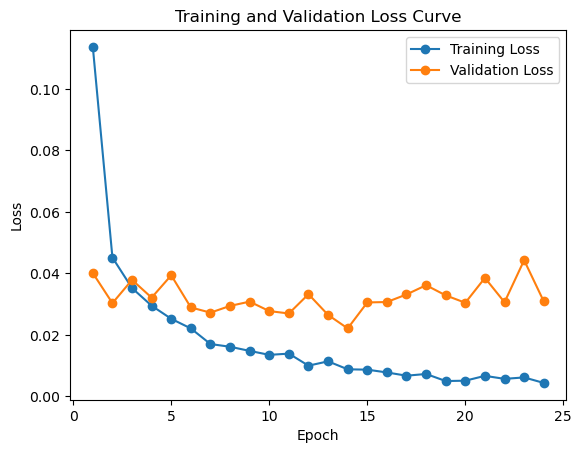

The best epoch is 14 with a validation loss of 0.0221


In [ ]:

# Plot the training and validation loss curves
plt.figure()
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()

print(f'The best epoch is {best_epoch} with a validation loss of {best_val_loss:.4f}')


### Test DA

In [ ]:
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({100. * correct / len(test_loader.dataset):.0f}%)\n')

### Test with *optimal* model

In [ ]:
# Load the best model weights
model.load_state_dict(torch.load('models/best_model_tot.pth'))

print(" Evaluate model on target_test: ")
test(model, target_test_loader, criterion)

 Evaluate model on target_test: 

Test set: Average loss: 0.0003, Accuracy: 9942/10000 (99%)



---

## Domain-Adversarial Neural Network (DANN)

### Define the DANN Model

In [ ]:
class GradReverse(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None

class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 4 * 4, 1024)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return x

class LabelPredictor(nn.Module):
    def __init__(self):
        super(LabelPredictor, self).__init__()
        self.fc1 = nn.Linear(1024, 100)
        self.fc2 = nn.Linear(100, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class DomainClassifier(nn.Module):
    def __init__(self):
        super(DomainClassifier, self).__init__()
        self.fc1 = nn.Linear(1024, 100)
        self.fc2 = nn.Linear(100, 2)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x, alpha):
        x = GradReverse.apply(x, alpha)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class DANN(nn.Module):
    def __init__(self):
        super(DANN, self).__init__()
        self.feature_extractor = FeatureExtractor()
        self.label_predictor = LabelPredictor()
        self.domain_classifier = DomainClassifier()

    def forward(self, x, alpha=1.0):
        features = self.feature_extractor(x)
        label_output = self.label_predictor(features)
        domain_output = self.domain_classifier(features, alpha)
        return label_output, domain_output


### Train the model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DANN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []

def train(model, source_loader, target_loader, optimizer, criterion, epoch):
    model.train()
    len_dataloader = min(len(source_loader), len(target_loader))
    data_zip = enumerate(zip(source_loader, target_loader))
    epoch_loss = 0.0
    
    for batch_idx, ((data_s, label_s), (data_t, _)) in data_zip:
        data_s, label_s = data_s.to(device), label_s.to(device)
        data_t = data_t.to(device)

        optimizer.zero_grad()

        # Training the label predictor
        p = float(batch_idx + epoch * len_dataloader) / (10 * len_dataloader)
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        label_output, domain_output_s = model(data_s, alpha=alpha)
        _, domain_output_t = model(data_t, alpha=alpha)

        loss_label = criterion(label_output, label_s)
        loss_domain_s = criterion(domain_output_s, torch.zeros(len(data_s), dtype=torch.long).to(device))
        loss_domain_t = criterion(domain_output_t, torch.ones(len(data_t), dtype=torch.long).to(device))

        loss = loss_label + loss_domain_s + loss_domain_t
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    average_loss = epoch_loss / len_dataloader
    train_losses.append(average_loss)
    print(f'====> Epoch: {epoch} Average train loss: {average_loss:.4f}')

def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.to(device), label.to(device)
            label_output, _ = model(data, alpha=0)  # alpha is not used during validation
            loss = criterion(label_output, label)
            val_loss += loss.item()
    
    average_val_loss = val_loss / len(val_loader)
    return average_val_loss

best_val_loss = float('inf')
best_epoch = -1
patience = 10
counter = 0

for epoch in range(1, 101):
    train(model, source_train_loader, target_train_loader, optimizer, criterion, epoch)
    val_loss = validate(model, source_test_loader, criterion)
    val_losses.append(val_loss)
    print(f'====> Epoch: {epoch} Validation loss: {val_loss:.4f}')
    
    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'models/best_model.pth')
        counter = 0  # Reset counter if validation loss improves
    else:
        counter += 1
    
    # Early stopping
    if counter >= patience:
        print(f'Early stopping at epoch {epoch}')
        break


====> Epoch: 1 Average train loss: 3.5263
====> Epoch: 1 Validation loss: 1.9291
====> Epoch: 2 Average train loss: 3.0806
====> Epoch: 2 Validation loss: 1.3849
====> Epoch: 3 Average train loss: 2.2430
====> Epoch: 3 Validation loss: 0.9143
====> Epoch: 4 Average train loss: 1.8892
====> Epoch: 4 Validation loss: 0.8736
====> Epoch: 5 Average train loss: 1.8111
====> Epoch: 5 Validation loss: 0.8782
====> Epoch: 6 Average train loss: 1.7665
====> Epoch: 6 Validation loss: 0.7201
====> Epoch: 7 Average train loss: 1.7413
====> Epoch: 7 Validation loss: 0.7998
====> Epoch: 8 Average train loss: 1.7132
====> Epoch: 8 Validation loss: 0.7096
====> Epoch: 9 Average train loss: 1.6934
====> Epoch: 9 Validation loss: 0.7423
====> Epoch: 10 Average train loss: 1.6754
====> Epoch: 10 Validation loss: 0.9886
====> Epoch: 11 Average train loss: 1.6629
====> Epoch: 11 Validation loss: 0.6353
====> Epoch: 12 Average train loss: 1.6423
====> Epoch: 12 Validation loss: 0.6411
====> Epoch: 13 Averag

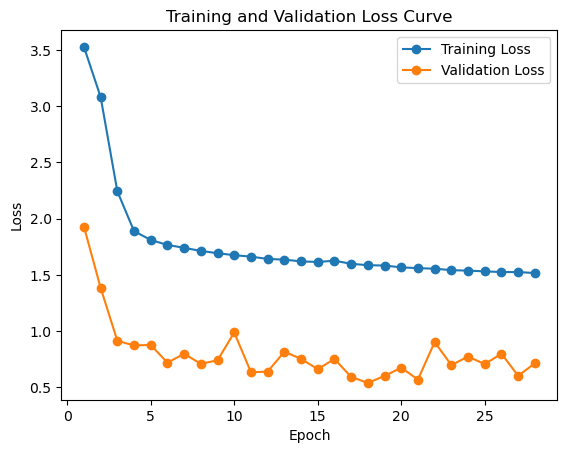

The best epoch is 18 with a validation loss of 0.5405


In [ ]:

# Plot the training and validation loss curves
plt.figure()
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()

print(f'The best epoch is {best_epoch} with a validation loss of {best_val_loss:.4f}')


In [ ]:
def test(model, target_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in target_loader:
            data, target = data.to(device), target.to(device)
            output, _ = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(target_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(target_loader.dataset)} '
          f'({100. * correct / len(target_loader.dataset):.0f}%)\n')

test(model, target_test_loader, criterion)


Test set: Average loss: 0.0352, Accuracy: 7798/10000 (78%)



---

## Results

Method|Accuracy on Target Domain
---|---
No Adaptation|70%
**DANN**|**78%**
Train on Target|99%